In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
%matplotlib inline
plt.ioff()
import pandas as pd

In [107]:
df = pd.read_csv('US_births_2000-2014_SSA.csv')

# 1. Day of Week Analysis

In [108]:
data = df.groupby('day_of_week').births.mean().reset_index()

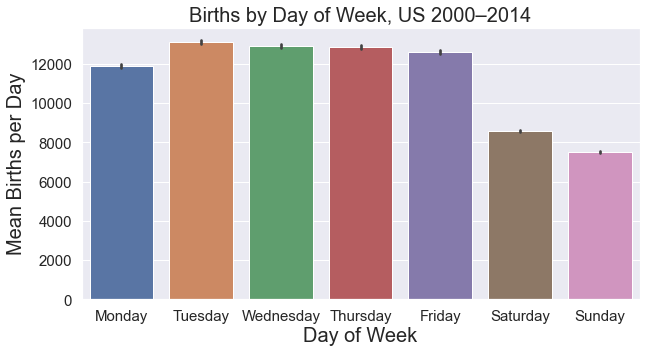

In [109]:
font_dict = {'fontsize' : 20}
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(
  data = df,
  x = 'day_of_week',
  y = 'births',
  ci = 99
)

ax.set_xlabel('Day of Week', fontdict = font_dict)
ax.set_xticklabels([
  'Monday',
  'Tuesday',
  'Wednesday',
  'Thursday',
  'Friday',
  'Saturday',
  'Sunday'
])
ax.set_ylabel('Mean Births per Day', fontdict = font_dict)
ax.set_title('Births by Day of Week, US 2000–2014', fontdict = font_dict)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
fig.savefig('outputs/dow.png')

plt.show()

# 2. KL–Div Analysis

In [110]:
from scipy.special import rel_entr as kl_div

In [111]:
# The Overall Distribution
empirical_p = (
  df.groupby(['month', 'date_of_month'])
    .births
    .sum()
    .rename('p_empirical')
)

empirical_p /= empirical_p.sum()

uniform_p = df.groupby(['month', 'date_of_month']).births.count().rename('p_uniform')
uniform_p = uniform_p / uniform_p.sum()

overall_p = pd.DataFrame(empirical_p).join(uniform_p)

In [112]:
# Compute the Probability for Each Year
yearly_p = (
  df.set_index(['month', 'date_of_month', 'year'])
    .groupby('year')
    .births
    .transform(lambda series : series/series.sum())
    .rename('p_empirical')
)

# Compute the Probability if that year were uniform (either 1/355 or 1/356)
uniform_p = 1 / (~yearly_p.unstack('year').isna()).sum().rename('p_uniform')
yearly_p = pd.DataFrame(yearly_p).join(uniform_p)



In [113]:
# Compute the KL-Divergence
overall_kl_div = kl_div(overall_p.p_empirical, overall_p.p_uniform).sum()
yearly_kl_div  = kl_div(yearly_p.p_empirical, yearly_p.p_uniform).groupby('year').sum()

In [114]:
print(f'Yearly  KL–Div : { yearly_kl_div.mean():.3f} ±{ yearly_kl_div.std():.3f}')
print(f'Overall KL-Div : {overall_kl_div.mean():.3f}')

Yearly  KL–Div : 0.022 ±0.003
Overall KL-Div : 0.002


In [115]:
divs = yearly_kl_div
divs['Overall'] = overall_kl_div
divs = divs.rename('kl_div').reset_index()

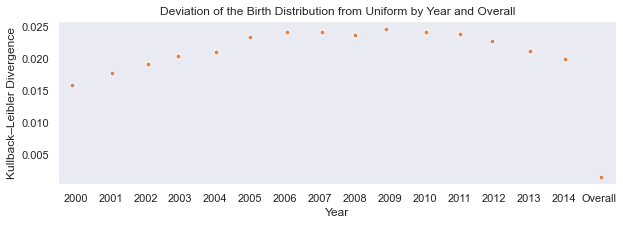

In [116]:
fig, ax = plt.subplots(figsize = (10, 3))
sns.stripplot(
  data = divs.reset_index(),
  y    = 'kl_div',
  x    = 'year',
  ax = ax,
  linewidth=1,
  edgecolor='w',
  orient = 'v',
  color = sns.color_palette()[1]
)

ax.set_ylabel('Kullback–Leibler Divergence')
ax.set_xlabel('Year')
ax.set_title('Deviation of the Birth Distribution from Uniform by Year and Overall')
ax.xaxis.grid(False)
ax.yaxis.grid(False)

fig.savefig('outputs/kl_div.png', bbox_inches = 'tight')

plt.show()

# 3. Regression Analysis

## 3.1 Code Holidays

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [118]:
def code_holiday(year, month, day, dow):
  '''Code holidays
  
  New Years (plus or minus a day)
  Valentines
  Leap Day
  Memorial Day (and the preceding weekend)
  July 4th (and the closest weekend)
  Labor Day (and the preceding weekend)
  Thanksgiving and the surrounding days
  Christmas and the surrounding days
  
  '''
  
  # New Years
  if (month, day) == (1, 1):
    return 'new_years'
  elif (month, day) == (12, 31):
    return 'new_years_eve'
  elif (month, day) == (1, 2):
    return 'day_after_new_years'
  
  # Valentines
  if (month, day) == (2, 14):
    return 'valentines'
  
  # Leap Day
  if (month, day) == (2, 29):
    return 'leap_day'
  
  # Memorial Day (Last Monday)
  if month == 5:
    if dow == 6   and day + 9 > 31 and day < 30: # Saturday before the last Monday
      return 'memorial_day_weekend'
    elif dow == 7 and day + 8 > 31 and day < 31: # Sunday before the last Monday
      return 'memorial_day_weekend'
    elif dow == 1 and day + 7 > 31: # last Monday
      return 'memorial_day'

  # July 4 and any adjacent weekends
  #  No weekends included if July 4 is Tue–Thur
  if month == 7:
    if day == 4:
      return 'july_4'
    if ((day == 2 and dow == 6) or      
        (day == 3 and dow in [6,7]) or  
        (day == 5 and dow in [6,7]) or
        (day == 6 and dow == 7)):
      return 'july_4_weekend'
    
  # Labor Day (first Monday of Sep)
  if month == 9:
    if dow == 1 and day - 7 < 1:
      return 'labor_day'
  if month == 8 and dow in [6, 7] and day + (8-dow) in [32, 33]:
    return 'labor_day_weekend'
  elif month == 9 and dow in [6, 7] and day - (dow-1) <= 0:
    return 'labor_day_weekend'
  
  # Thanksgiving (4th Thursday in Nov)
  #  also includes contiguous Wed and Friday and Sat/Sun 
  if month in [11,12]:
    nearest_thur = day + (4 - dow)
    # Mondays projected forwards, Sundays backwards
    if month == 12 and nearest_thur <= 0:
      month = 11
      nearest_thur += 30
      
    if month == 11 and nearest_thur - 21 > 0 and nearest_thur - 21 <= 7:
      if dow == 4:
        return 'thanksgiving'
      elif dow in [5, 6, 7]:
        return 'thanksgiving_weekend'
      elif dow == 3:
        return 'day_before_thanksgiving'
      
  # Christmas (Dec 25)
  #  also includes: the eve, the day after
  if month == 12:
    if day == 25:
      return 'christmas'
    elif day == 24:
      return 'christmas_eve'
    elif day == 26:
      return 'day_after_christmas'
    
  return 'regular_day'

In [119]:
holidays = df.apply(
  lambda row : code_holiday(row.year, row.month, row.date_of_month, row.day_of_week)
, axis = 'columns')

holiday_encode = OneHotEncoder(drop = ['regular_day'], sparse = False)
holiday_df = holiday_encode.fit_transform(pd.DataFrame(holidays))
holiday_df = (
  pd.DataFrame(
      holiday_df,
      columns=np.delete(holiday_encode.categories_[0].copy(), holiday_encode.drop_idx_[0]),
      index=df.index
   ).astype(int)
)

In [120]:
# # Look at the holidays coded
# pd.options.display.max_rows = 400

# pd.concat([
#   df,
#   holidays
# ], axis = 'columns')[holiday_df.sum(axis = 'columns') == 1]

## 3.2 Code the Month and Day of Week

In [121]:
months = [
  'January',
  'February',
  'March',
  'April',
  'May',
  'June',
  'July',
  'August',
  'September',
  'October',
  'November',
  'December',
]

days = [
  'Monday',
  'Tuesday',
  'Wednesday',
  'Thursday',
  'Friday',
  'Saturday',
  'Sunday'
]

In [122]:
def encode_col(data, english_names):
  names = dict(enumerate(english_names))
  def name(n):
    return names[n-1]
  
  df = data.apply(name)
  ohe  = OneHotEncoder(drop = 'first', categories = [english_names], sparse = False)
  df = ohe.fit_transform(pd.DataFrame(df))
    
  return pd.DataFrame(
      df,
      columns=np.delete(ohe.categories_[0].copy(), ohe.drop_idx_[0]),
      index=data.index
   ).astype(int)


In [124]:
month_df = encode_col(df.month, months)
dow_df   = encode_col(df.day_of_week, months)

## 3.3 Fit the Model

In [139]:
X = pd.concat([
  df.year - 2000,
  month_df,
  dow_df,
  holiday_df
], axis = 'columns')

y = df.births

In [141]:
model = LinearRegression()
model.fit(X, y)

In [145]:
coefs = pd.Series(model.coef_, index = X.columns)
coefs['Intercept'] = model.intercept_
coefs

year                      -3.281297e+01
February                   7.798646e+01
March                      8.530748e+01
April                     -1.864617e+01
May                        2.333691e+02
June                       4.408610e+02
July                       7.984743e+02
August                     8.602435e+02
September                  1.139827e+03
October                    3.370078e+02
November                   4.429277e+02
December                   5.304953e+02
February                   1.060917e+03
March                      8.706701e+02
April                      8.827181e+02
May                        5.477799e+02
June                      -3.476887e+03
July                      -4.514779e+03
August                    -3.865352e-12
September                  1.818989e-12
October                    2.188472e-12
November                   6.252776e-13
December                  -1.108447e-12
christmas                 -5.279009e+03
christmas_eve             -3.588616e+03


In [152]:
model.score(X, y)

0.943696795510416